In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

engine = create_engine('sqlite:///MyDB.sqlite3', echo=True)  # 挂载引擎到Pandas上
data = pd.read_sql("select name, level, hot,num, price, area from item;", con=engine)

2018-10-26 12:43:39,769 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-10-26 12:43:39,777 INFO sqlalchemy.engine.base.Engine ()
2018-10-26 12:43:39,779 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-10-26 12:43:39,780 INFO sqlalchemy.engine.base.Engine ()
2018-10-26 12:43:39,782 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("select name, level, hot,num, price, area from item;")
2018-10-26 12:43:39,783 INFO sqlalchemy.engine.base.Engine ()
2018-10-26 12:43:39,788 INFO sqlalchemy.engine.base.Engine select name, level, hot,num, price, area from item;
2018-10-26 12:43:39,789 INFO sqlalchemy.engine.base.Engine ()


In [2]:
data["area"] = data["area"].apply(lambda x: x.replace("[", "").replace("]", ""))
data["province"] = data["area"].apply(lambda x: x.split("·")[0])  # 获取省信息
data["city"] = data["area"].apply(lambda x: x.split("·")[1])  # 获取市信息

c:\users\11150\appdata\local\programs\python\python35-32\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


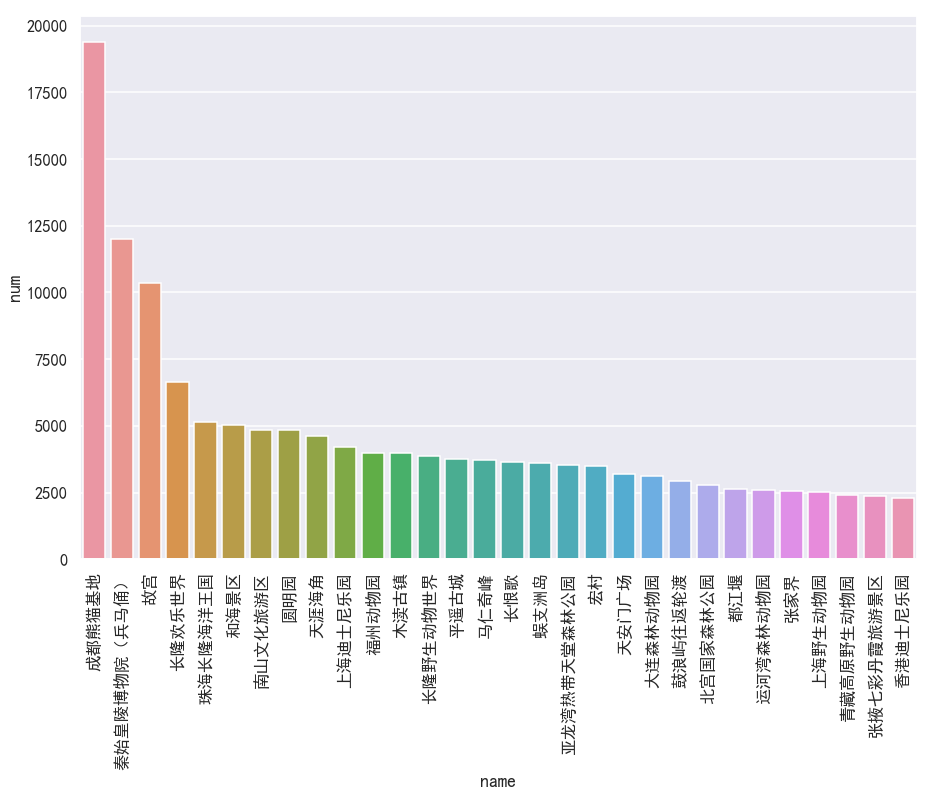

In [3]:
# 销量最多的前30景点`
num_top = data.sort_values(by='num', axis=0, ascending=False).reset_index(drop=True)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题
sns.set_context("talk")
fig = plt.figure(figsize=(15, 10))
sns.barplot(num_top["name"][:30], num_top["num"][:30])
plt.xticks(rotation=90)
fig.show()

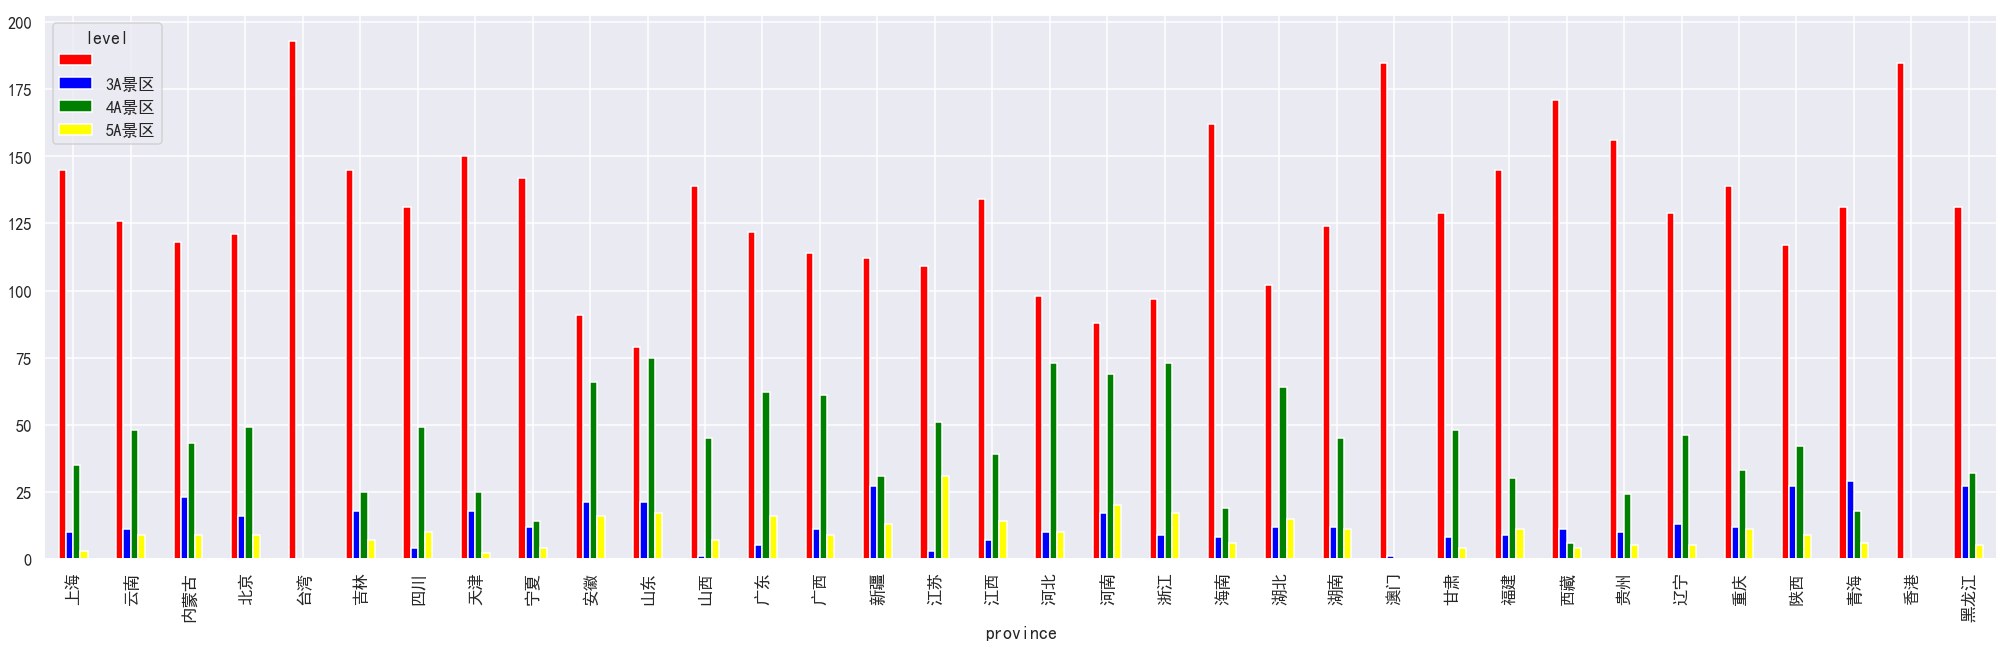

In [5]:
# 省份与景区评级
data['level_sum'] = 1  # 给所有行添加一列数据level_sum，值为1，用来记录总个数
var = data.groupby(['province', 'level']).level_sum.sum()
var.unstack().plot(kind='bar', figsize=(35, 10), stacked=False, color=['red', 'blue', 'green', 'yellow'])

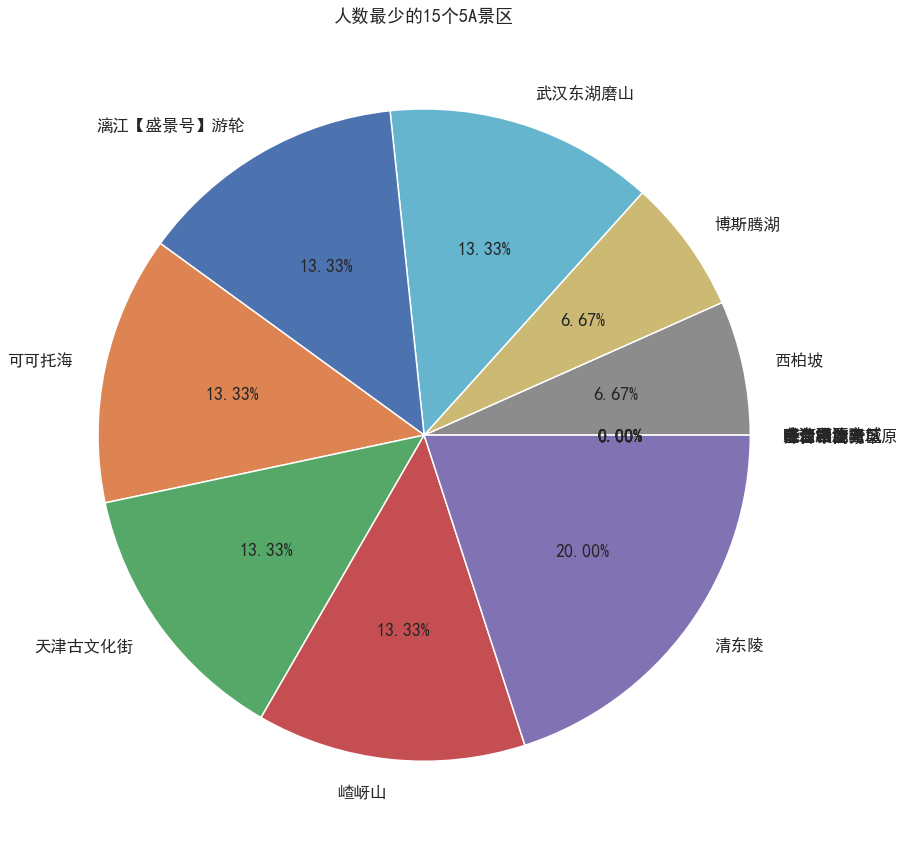

In [6]:
# 人少的5A景点，4A景点，3A景点
top_5A = data[data["level"] == "5A景区"].sort_values(by='num', axis=0, ascending=True).reset_index(drop=True)
top_4A = data[data["level"] == "4A景区"].sort_values(by='num', axis=0, ascending=True).reset_index(drop=True)
top_3A = data[data["level"] == "3A景区"].sort_values(by='num', axis=0, ascending=True).reset_index(drop=True)
fig = plt.figure(figsize=(15, 15))
plt.pie(top_5A["num"][:15], labels=top_5A["name"][:15], autopct='%1.2f%%')
plt.title("人数最少的15个5A景区")
plt.show()

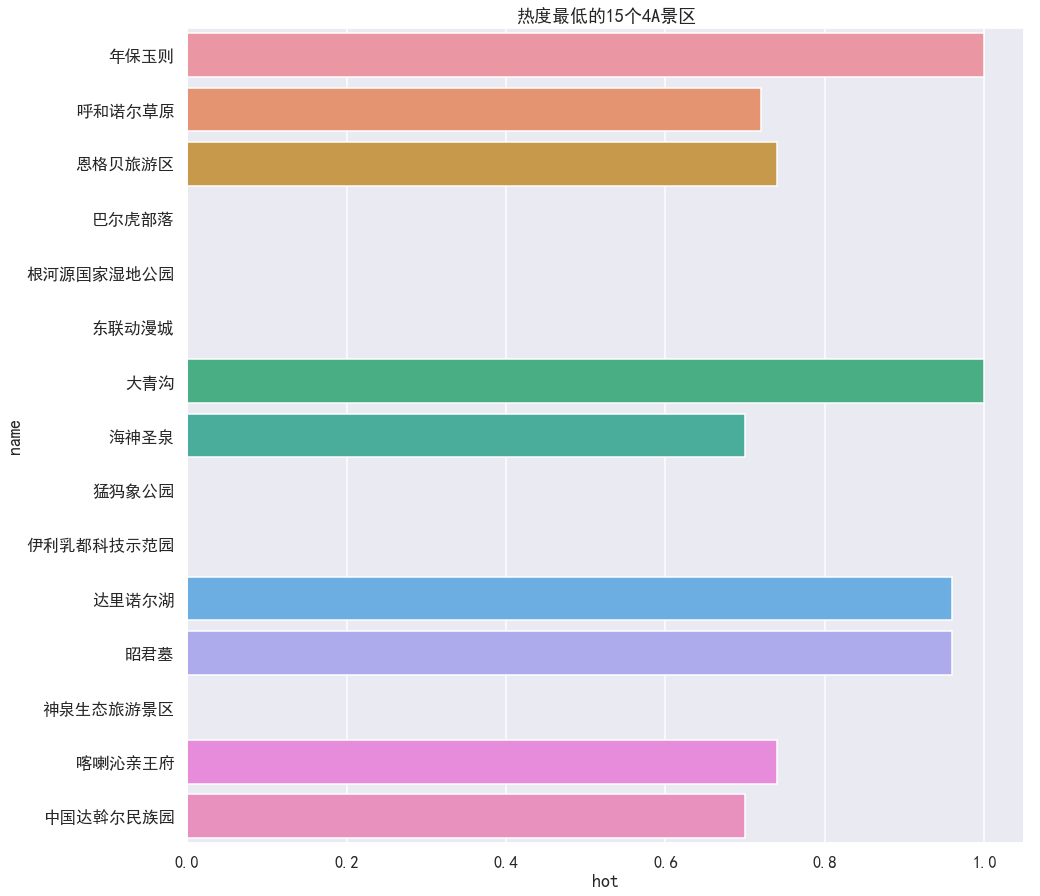

In [7]:
fig = plt.figure(figsize=(15, 15))
ax = sns.barplot(top_4A["hot"][:15], top_4A["name"][:15])
ax.set_title("热度最低的15个4A景区")
fig.show()

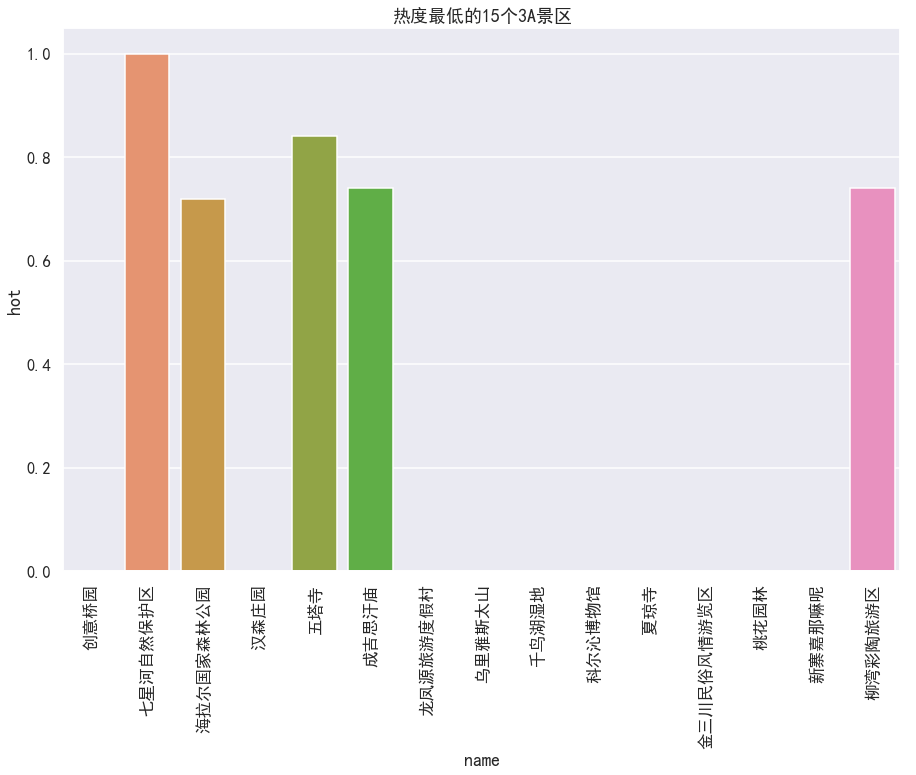

In [8]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(top_3A["name"][:15], top_3A["hot"][:15])
ax.set_title("热度最低的15个3A景区")
plt.xticks(rotation=90)
fig.show()

In [10]:
data = data[(data['level'] != '')]

city = list(set(data['province']))
data['province'] = data['province'].apply(lambda x:city.index(x))

train_data = data[['price', 'num', 'hot', 'province']]

from sklearn.preprocessing import scale
import numpy as np

train_data = scale(train_data)

y = data[['level']]

from imblearn.over_sampling import  SMOTE
from imblearn.under_sampling import RepeatedEditedNearestNeighbours

train_data, y =  SMOTE().fit_sample(train_data, y)
train_data, y =  RepeatedEditedNearestNeighbours(random_state=0).fit_sample(train_data, y)
x_train,x_test,y_train,y_test = train_test_split(train_data,y,test_size=0.2, stratify=y)

c:\users\11150\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
c:\users\11150\appdata\local\programs\python\python35-32\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
rf = RandomForestClassifier(n_estimators=100,oob_score=True, n_jobs=1)    # max_depth=10最大树深,
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
score = rf.score(x_test,y_test)
print(score)

0.8615384615384616


In [12]:
from sklearn.metrics import classification_report

"""
精确度: 表示的是预测为正的样本中有多少是真正的正样本。
召回率:表示的是样本中的正例有多少被预测正确了。
F1值:2*精度*召回率/(精度+召回率)
支持数: 该类在样本中出现的总次数
"""

print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

        3A景区       0.90      0.86      0.88       143
        4A景区       0.85      0.85      0.85       268
        5A景区       0.84      0.87      0.86       174

   micro avg       0.86      0.86      0.86       585
   macro avg       0.87      0.86      0.86       585
weighted avg       0.86      0.86      0.86       585



In [242]:
from sklearn.externals import joblib

joblib.dump(rf, 'random_forest_stome_renn.pkl')

['random_forest_stome_renn.pkl']